## Data *Gathering*

mengumpulkan dataset dari kaggle https://www.kaggle.com/datasets/daniel09817/twitter-sentiment-analysis


In [1]:
!kaggle datasets download -d daniel09817/twitter-sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/daniel09817/twitter-sentiment-analysis
License(s): other
 98% 40.0M/40.9M [00:00<00:00, 62.8MB/s]
100% 40.9M/40.9M [00:00<00:00, 61.3MB/s]


In [25]:
!unzip twitter-sentiment-analysis.zip

Archive:  twitter-sentiment-analysis.zip
  inflating: twitter sentiment analysis.csv  


### Import Semua Liblaries Yang Digunakan

mengimport semua liblares yang digunakan dalam notebook ini

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

## Accessing data

In [27]:
df = pd.read_csv('/content/twitter sentiment analysis.csv')
df.head()


,Text,Label
0,rwanda is set to host the headquarters of unit...,positive
1,it sucks for me since im focused on the nature...,negative
2,shawntarloff itsmieu you can also relate this ...,neutral
3,social security constant political crises dist...,negative
4,filmthepolicela a broken rib can puncture a lu...,negative


In [28]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691248 entries, 0 to 691247
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Text    691244 non-null  object
 1   Label   691248 non-null  object
dtypes: object(2)
memory usage: 10.5+ MB


###Data Cleaning

In [31]:
df.isnull().sum()

,0
Text,4
Label,0


In [7]:
df.dropna(inplace=True)

In [34]:
df.duplicated(subset='Text').sum()

20825

In [9]:
df.drop_duplicates(subset='Text',inplace=True)

In [29]:
df.describe()

,Text,Label
count,691244,691248
unique,670422,3
top,surprisingly controversial topics might just b...,positive
freq,491,248516


### EDA

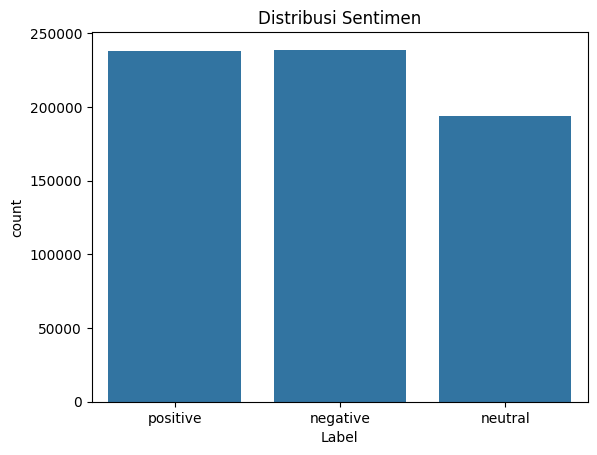

In [11]:
sns.countplot(x='Label', data=df)
plt.title('Distribusi Sentimen')
plt.show()


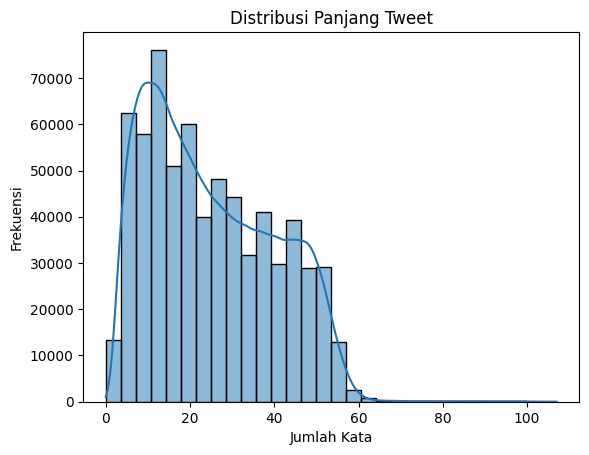

In [12]:
df['tweet_length'] = df['Text'].apply(lambda x: len(x.split()))  # Hitung jumlah kata
sns.histplot(df['tweet_length'], bins=30, kde=True)
plt.title('Distribusi Panjang Tweet')
plt.xlabel('Jumlah Kata')
plt.ylabel('Frekuensi')
plt.show()


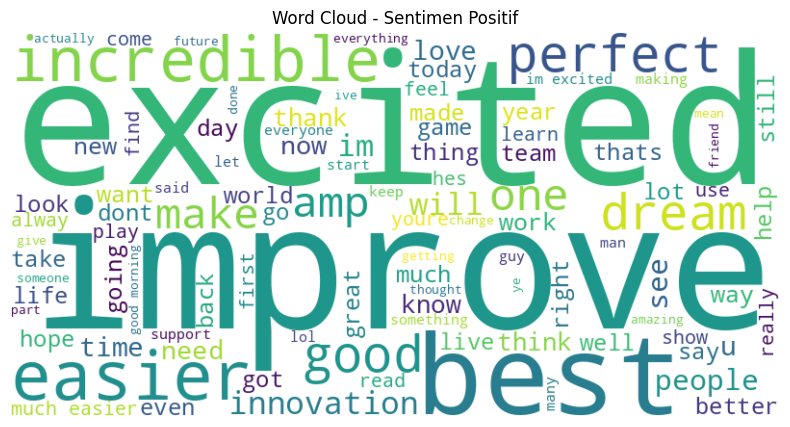

In [13]:
# Word Cloud untuk sentimen positif
positive_tweets = ' '.join(df[df['Label'] == 'positive']['Text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(positive_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Positif')
plt.show()


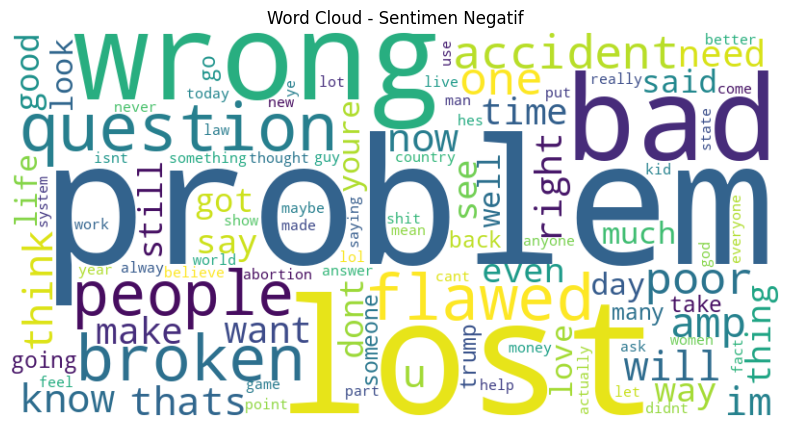

In [14]:
# Word Cloud untuk sentimen negatif
negative_tweets = ' '.join(df[df['Label'] == 'negative']['Text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(negative_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen Negatif')
plt.show()


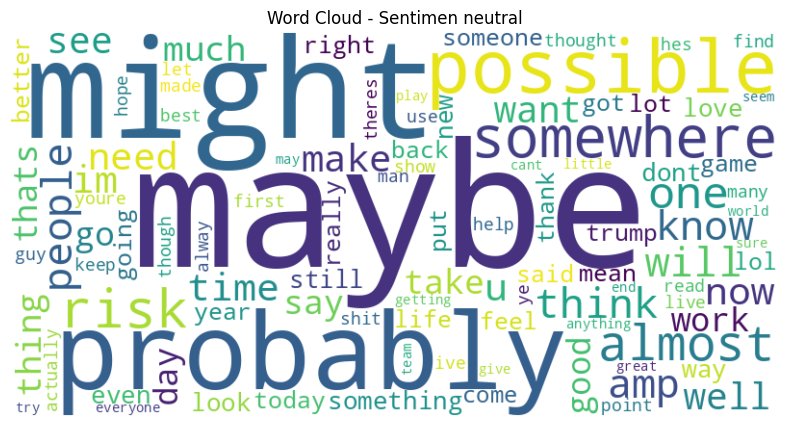

In [15]:
# Word Cloud untuk sentimen neutral
neutral_tweets = ' '.join(df[df['Label'] == 'neutral']['Text'])
wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(neutral_tweets)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud - Sentimen neutral')
plt.show()


###Data Preparation

mengubah teks menjadi huruf kecil, Menghapus mention dan URL ,menghapus tanda baca dan angka dan menghapus stop words

In [16]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Daftar stopwords
stop_words = set(stopwords.words('english'))

# Fungsi untuk membersihkan teks
def clean_text(text):
    text = text.lower()  # Mengubah teks menjadi huruf kecil
    text = re.sub(r'@\w+|http\S+', '', text)  # Menghapus mention dan URL
    text = re.sub(r'[^a-z\s]', '', text)  # Menghapus tanda baca dan angka
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Menghapus stopwords
    return text

df['clean_text'] = df['Text'].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


tokenisasi dan stemming

In [17]:
from nltk.stem import PorterStemmer

ps = PorterStemmer()

# Fungsi untuk tokenisasi dan stemming
def stem_text(text):
    tokens = text.split()
    return ' '.join([ps.stem(word) for word in tokens])

df['stemmed_text'] = df['clean_text'].apply(stem_text)


TF ID vectorizer

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['stemmed_text'])
y = df['Label']  # Label target


membagi data train dan test

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Modelling

model devault linear svc

In [20]:
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Membuat model SVM dasar
linear_svc_model = LinearSVC()  # Menggunakan parameter default
linear_svc_model.fit(X_train, y_train)

# Evaluasi model pada data uji
y_pred = linear_svc_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.97      0.97      0.97     47674
     neutral       0.96      0.96      0.96     38723
    positive       0.98      0.97      0.98     47688

    accuracy                           0.97    134085
   macro avg       0.97      0.97      0.97    134085
weighted avg       0.97      0.97      0.97    134085



tuning parameter model linear svc menggunakan grid search

In [22]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Definisikan parameter untuk GridSearch
param_grid = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l2'],  # LinearSVC hanya mendukung 'l2' jika dual=True
    'loss': ['hinge', 'squared_hinge'],
    'max_iter': [1000, 2000, 5000]
}

# Membangun model dengan GridSearchCV
grid_search = GridSearchCV(LinearSVC(), param_grid, refit=True, verbose=2, cv=5)
grid_search.fit(X_train, y_train)

# Hasil parameter terbaik
print("Best Parameters: ", grid_search.best_params_)

# Evaluasi model yang di-tune pada data uji
y_pred_tuned = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_tuned))


Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END .......C=0.1, loss=hinge, max_iter=1000, penalty=l2; total time=   7.6s
[CV] END .......C=0.1, loss=hinge, max_iter=1000, penalty=l2; total time=   7.8s
[CV] END .......C=0.1, loss=hinge, max_iter=1000, penalty=l2; total time=   6.7s
[CV] END .......C=0.1, loss=hinge, max_iter=1000, penalty=l2; total time=   7.0s
[CV] END .......C=0.1, loss=hinge, max_iter=1000, penalty=l2; total time=   7.2s
[CV] END .......C=0.1, loss=hinge, max_iter=2000, penalty=l2; total time=   7.2s
[CV] END .......C=0.1, loss=hinge, max_iter=2000, penalty=l2; total time=   7.0s
[CV] END .......C=0.1, loss=hinge, max_iter=2000, penalty=l2; total time=   7.7s
[CV] END .......C=0.1, loss=hinge, max_iter=2000, penalty=l2; total time=   7.4s
[CV] END .......C=0.1, loss=hinge, max_iter=2000, penalty=l2; total time=   9.0s
[CV] END .......C=0.1, loss=hinge, max_iter=5000, penalty=l2; total time=   7.3s
[CV] END .......C=0.1, loss=hinge, max_iter=500

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=1000, penalty=l2; total time=  11.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=1000, penalty=l2; total time=  12.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=1000, penalty=l2; total time=  12.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=1000, penalty=l2; total time=  13.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=1000, penalty=l2; total time=  13.3s
[CV] END .........C=1, loss=hinge, max_iter=2000, penalty=l2; total time=  16.3s
[CV] END .........C=1, loss=hinge, max_iter=2000, penalty=l2; total time=  15.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=2000, penalty=l2; total time=  20.8s
[CV] END .........C=1, loss=hinge, max_iter=2000, penalty=l2; total time=  17.7s
[CV] END .........C=1, loss=hinge, max_iter=2000, penalty=l2; total time=  18.3s
[CV] END .........C=1, loss=hinge, max_iter=5000, penalty=l2; total time=  18.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .........C=1, loss=hinge, max_iter=5000, penalty=l2; total time=  20.1s
[CV] END .........C=1, loss=hinge, max_iter=5000, penalty=l2; total time=  22.4s
[CV] END .........C=1, loss=hinge, max_iter=5000, penalty=l2; total time=  18.0s
[CV] END .........C=1, loss=hinge, max_iter=5000, penalty=l2; total time=  17.0s
[CV] END .C=1, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  12.0s
[CV] END .C=1, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  11.6s
[CV] END .C=1, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  12.4s
[CV] END .C=1, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  11.7s
[CV] END .C=1, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  12.5s
[CV] END .C=1, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  13.4s
[CV] END .C=1, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  11.7s
[CV] END .C=1, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  12.5s
[CV] END .C=1, loss=squared_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=1000, penalty=l2; total time=  25.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=1000, penalty=l2; total time=  25.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=1000, penalty=l2; total time=  30.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=1000, penalty=l2; total time=  35.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=1000, penalty=l2; total time=  24.9s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=2000, penalty=l2; total time=  49.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=2000, penalty=l2; total time=  38.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=2000, penalty=l2; total time=  43.8s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=2000, penalty=l2; total time=  35.0s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=2000, penalty=l2; total time=  34.2s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=5000, penalty=l2; total time=  53.6s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=5000, penalty=l2; total time=  53.7s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=5000, penalty=l2; total time=  50.5s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=5000, penalty=l2; total time=  51.4s


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END ........C=10, loss=hinge, max_iter=5000, penalty=l2; total time=  52.3s
[CV] END C=10, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  16.3s
[CV] END C=10, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  17.7s
[CV] END C=10, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  15.7s
[CV] END C=10, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  17.4s
[CV] END C=10, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  15.9s
[CV] END C=10, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  16.2s
[CV] END C=10, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  16.7s
[CV] END C=10, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  16.7s
[CV] END C=10, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  17.8s
[CV] END C=10, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  16.0s
[CV] END C=10, loss=squared_hinge, max_iter=5000, penalty=l2; total time=  16.2s
[CV] END C=10, loss=squared_

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=1000, penalty=l2; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=1000, penalty=l2; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=1000, penalty=l2; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=1000, penalty=l2; total time= 1.9min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=1000, penalty=l2; total time= 1.8min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=2000, penalty=l2; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=2000, penalty=l2; total time= 2.2min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=2000, penalty=l2; total time= 2.0min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=2000, penalty=l2; total time= 2.1min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=2000, penalty=l2; total time= 2.3min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=5000, penalty=l2; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=5000, penalty=l2; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=5000, penalty=l2; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=5000, penalty=l2; total time= 2.6min


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV] END .......C=100, loss=hinge, max_iter=5000, penalty=l2; total time= 2.6min
[CV] END C=100, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  18.9s
[CV] END C=100, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  20.0s
[CV] END C=100, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  19.1s
[CV] END C=100, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  21.4s
[CV] END C=100, loss=squared_hinge, max_iter=1000, penalty=l2; total time=  21.3s
[CV] END C=100, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  18.8s
[CV] END C=100, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  20.3s
[CV] END C=100, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  18.7s
[CV] END C=100, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  21.5s
[CV] END C=100, loss=squared_hinge, max_iter=2000, penalty=l2; total time=  20.9s
[CV] END C=100, loss=squared_hinge, max_iter=5000, penalty=l2; total time=  18.9s
[CV] END C=100, l